In [1]:
%reset
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Change the current working directory to the desired path
os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')
import pyccl as ccl


%load_ext autoreload
%autoreload 2



In [2]:
# cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
cosmo = ccl.Cosmology(
    Omega_c=0.31-0.049, Omega_b=0.049, h=0.672, sigma8=0.81, n_s=0.95,
    transfer_function='eisenstein_hu')



In [3]:
k_array_ccl = np.logspace(-4, 2, 100)
z = 0.0
pkz_HF_ccl = ccl.nonlin_matter_power(cosmo, k=k_array_ccl, a=1/(1+z))



In [4]:
from pyccl.halos.profiles import nfw
from pyccl.halos.concentration import duffy08



In [5]:
conc_model_ccl = duffy08.ConcentrationDuffy08()
nfw_prof_ccl = nfw.HaloProfileNFW(mass_def='200c',concentration=conc_model_ccl)



In [6]:
r_array = np.logspace(-2, 0, 100)
z_test = 1.0
h = cosmo['h']
M_test = 1.07710506e+14
conc = conc_model_ccl._concentration(cosmo,M_test/h,1/(1+z_test))



In [7]:
prof_test_ccl = nfw_prof_ccl._real(cosmo,r_array/h,M_test/h,1/(1+z_test))/(h**2)



In [178]:
from colossus.cosmology import cosmology
cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['gamma_rhogas'] = 2.0
sim_params_dict['delta_rhogas'] = 7.0
sim_params_dict['theta_co'] = 0.1
sim_params_dict['theta_ej'] = 4.0
sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['log10_M1_starcga'] = 11.4
sim_params_dict['epsilon_rt'] = 4.0
sim_params_dict['log10_Mc0'] = 14.83
sim_params_dict['nu_z'] = 0.0
sim_params_dict['nu_M'] = 0.0
sim_params_dict['log10_Mstar0'] = 13.0
sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.3
sim_params_dict['cosmo'] = cosmo_params_dict


halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 1e-3, 5, 33
halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.01, 1.4, 31
halo_params_dict['Mmin'], halo_params_dict['Mmax'], halo_params_dict['nM'] = 1e12, 1e15, 32
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 2, 8, 34
halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**15, 64
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.01
halo_params_dict['mdef'] = '200c'
halo_params_dict['hmf_model'] = 'T08'
halo_params_dict['do_corr_2h_mm'] = True
# halo_params_dict['do_corr_2h_mm'] = False

from astropy.io import fits
df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/sim_3x2pt_simulated_DV_PKproject_values_bestfit_maglim_3x2LCDM_final.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 4
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-3)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-3)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-3)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-3)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True
analysis_dict['do_yy'] = True

df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DES_ACT_full_data_theorycov_2.5.fits')
theta_data = df_data['compton_shear'].data['ANG'][0:20]

analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 16384
analysis_dict['angles_data_array'] = jnp.array(theta_data)
analysis_dict['beam_fwhm_arcmin'] = 1.6
analysis_dict['want_like_diff'] = True
analysis_dict['calc_nfw_only'] = True





In [111]:
from get_BCMP_profile_jit import BCM_18_wP
BCMP_test = BCM_18_wP(sim_params_dict, halo_params_dict)


In [112]:
indc = np.where(BCMP_test.conc_array > 0.95*conc)[0][0]
indz = np.where(BCMP_test.z_array > 0.95*z_test)[0][0]
indM = np.where(BCMP_test.M200c_array > 0.95*M_test)[0][0]



(1000000000000.0, 20000000000000.0)

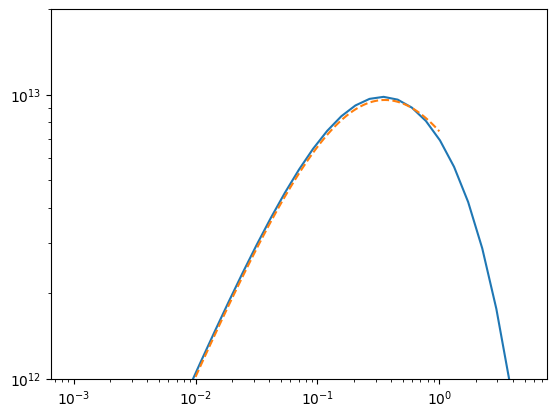

In [113]:
pl.figure()
pl.loglog(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.rho_nfw_mat[:,indc,indz,indM])
pl.loglog(r_array, (r_array**2)*prof_test_ccl, '--')
pl.ylim(1e12, 2e13)



In [29]:
BCMP_test.Pth_mat.shape

(33, 34, 31, 32)

(1e-07, 2)

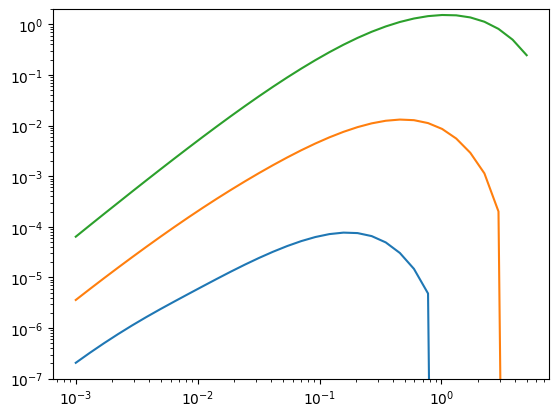

In [114]:
pl.figure()
# pl.loglog(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.Pth_mat[:,indc,indz,indM])
# pl.loglog(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.Pth_mat[:,indc,indz,0])
# pl.loglog(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.Pth_mat[:,indc,indz,16])
# pl.loglog(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.Pth_mat[:,indc,indz,31])

pl.loglog(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.Pth_mat[:,indc,0,0])
pl.loglog(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.Pth_mat[:,indc,0,16])
pl.loglog(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.Pth_mat[:,indc,0,31])

# pl.loglog(r_array, (r_array**2)*prof_test_ccl, '--')
pl.ylim(1e-7, 2)



In [153]:
from setup_power_spectra_jit import setup_power_BCMP

setup_power_BCMP_test = setup_power_BCMP(sim_params_dict, halo_params_dict, analysis_dict, num_points_trapz_int=64, verbose_time=True)




Time taken to calculate BCMP profile:  4.000538349151611  seconds
Time taken to setup Pk:  2.6220738887786865
Time taken to setup HMF:  5.2410008907318115
Time taken to setup uks and bks:  1.3096227645874023
Time taken to setup uls and bls:  2.2892749309539795
Time taken to setup power spectra:  12.41443395614624


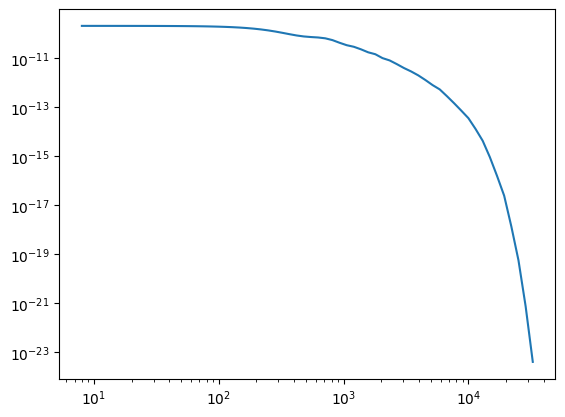

In [155]:
pl.figure()
# pl.loglog(setup_power_BCMP_test.ell_array, uyl_here)
pl.loglog(setup_power_BCMP_test.ell_array, setup_power_BCMP_test.uyl_mat[:,indc,4,30])




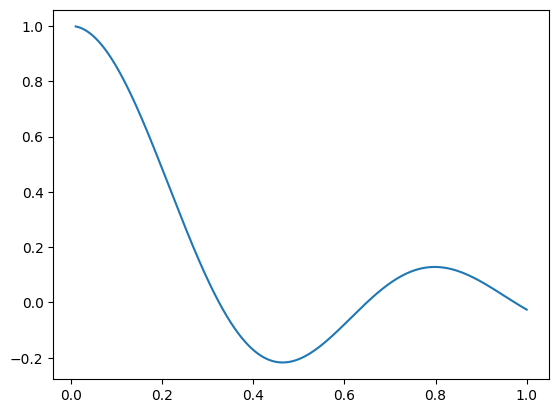

In [152]:
ell = 4000
r_array_int = np.logspace(-2, 0, 1000)
chiz = setup_power_BCMP_test.chi_array[2]
sin_fac = (jnp.sin((ell + 0.5)*r_array_int/chiz))/(((ell + 0.5)*r_array_int/chiz))
pl.figure()
pl.plot(r_array_int, sin_fac)



In [ ]:
pl.figure()
# pl.loglog(setup_power_BCMP_test.ell_array, uyl_here)
pl.loglog(setup_power_BCMP_test.ell_array, setup_power_BCMP_test.uyl_mat[:,indc,4,25])




In [99]:
xmin=0.01
xmax=3
num_points_trapz_int=16384
# jl = 10
# jc = 0
# jz = 0
# jM = 20
def get_uyl(jl,self=setup_power_BCMP_test, jc=indc, jz=0, jM=5, xmin=0.01, xmax=3, num_points_trapz_int=16384):
        # r200c = self.r200c_mat[jz, jM]
        # z = self.z_array[jz]
        # az = 1.0 / (1.0 + z)
        # Da_z = angular_diameter_distance(self.cosmo_jax, az)
        # Da_z = jnp.clip(self.DA_array[jz], 1.0)
        # l200c = Da_z/r200c
        # prefac = r200c/l200c**2
        chiz = jnp.clip(self.chi_array[jz], 1.0)
        az = 1.0 / (1.0 + self.z_array[jz])
        prefac = az/(chiz**2)
        rmin = xmin * self.r200c_mat[jz, jM]
        rmax = xmax * self.r200c_mat[jz, jM]
        # logr_array_int = jnp.linspace(jnp.log(rmin), jnp.log(rmax), num_points_trapz_int)
        # r_array_int = jnp.exp(logr_array_int)

        r_array_int = jnp.linspace((rmin), (rmax), num_points_trapz_int)
        logr_array_int = jnp.log(r_array_int)

        # x_array = jnp.exp(logx_array)

        y3d_min = jnp.min(jnp.absolute(self.y3d_mat[:,jc, jz, jM]))
        y3d_clipped = jnp.clip(self.y3d_mat[:,jc, jz, jM], y3d_min + 1e-25)
        # y3d_xarray = jnp.exp(jnp.interp(logx_array, jnp.log(self.r_array/r200c), jnp.log(self.y3d_mat[:,jc, jz, jM])))
        y3d_rarray = jnp.exp(jnp.interp(logr_array_int, jnp.log(self.r_array), jnp.log(y3d_clipped)))        
        ell = self.ell_array[jl]
        sin_fac = (jnp.sin((ell + 0.5)*r_array_int/chiz))/(((ell + 0.5)*r_array_int/chiz))

        fx = y3d_rarray * sin_fac * (4*jnp.pi*r_array_int**2)
        uyl = prefac * jnp.trapz(fx, x=r_array_int)
        Bl = jnp.exp(-1. * ell * (ell + 1) * (self.sig_beam ** 2) / 2.)
        return uyl * Bl

uyl_here = vmap(get_uyl)(jnp.arange(len(setup_power_BCMP_test.ell_array)))



In [106]:
from mcfit import xi2P
def get_uyl_mcfit(jl,self=setup_power_BCMP_test, jc=indc, jz=0, jM=5, xmin=0.01, xmax=3, num_points_trapz_int=128):
    chiz = jnp.clip(self.chi_array[jz], 1.0)
    az = 1.0 / (1.0 + self.z_array[jz])
    prefac = az/(chiz**2)

    y3d_min = jnp.min(jnp.absolute(self.y3d_mat[:,jc, jz, jM]))
    y3d_clipped = jnp.clip(self.y3d_mat[:,jc, jz, jM], y3d_min + 1e-30)
    # r_array_mcfit = np.array(self.r_array/chiz)
    # r_array_mcfit = self.r_array/chiz
    logr_array_mcfit = jnp.linspace(jnp.log(jnp.min(self.r_array/chiz)), jnp.log(jnp.max(self.r_array/chiz)), num_points_trapz_int)
    r_array_mcfit = jnp.exp(logr_array_mcfit)
    y3d_array = jnp.exp(jnp.interp(jnp.log(r_array_mcfit), jnp.log(self.r_array/chiz), jnp.log(y3d_clipped)))
    # y3d_array = np.array(y3d_clipped)
    k_mcfit, uy_mcfit = (xi2P(r_array_mcfit,lowring=True)(y3d_array,  extrap=False))
    uy_mcfit = jnp.array(uy_mcfit)
    ell = self.ell_array[jl]
    uyl = prefac *  (chiz**3) * jnp.exp(jnp.interp(jnp.log(ell), jnp.log(k_mcfit), jnp.log(uy_mcfit)))
    Bl = jnp.exp(-1. * ell * (ell + 1) * (self.sig_beam ** 2) / 2.) 
    return uyl * Bl 
uyl_here_mcfit = vmap(get_uyl_mcfit)(jnp.arange(len(setup_power_BCMP_test.ell_array)))


In [109]:
# setup_power_BCMP_test.sig_beam
# r_array_mcfit


NameError: name 'r_array_mcfit' is not defined

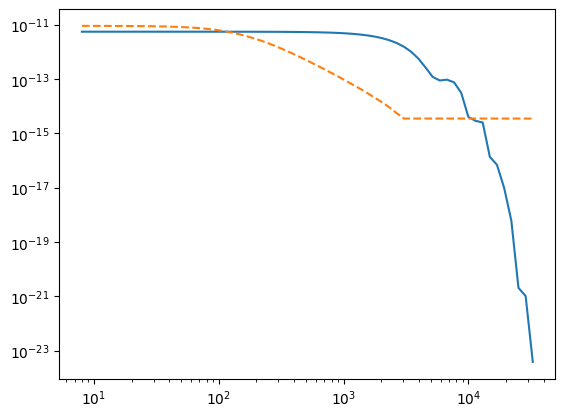

In [144]:
# setup_power_BCMP_test.uyl_mat.shape
pl.figure()
# pl.loglog(setup_power_BCMP_test.ell_array, uyl_here)
pl.loglog(setup_power_BCMP_test.ell_array, setup_power_BCMP_test.uyl_mat[:,indc,4,25])
# pl.loglog(setup_power_BCMP_test.ell_array, uyl_here_mcfit, '--')



In [143]:
# np.log10(setup_power_BCMP_test.M_array)


array([12.        , 12.09677419, 12.19354839, 12.29032258, 12.38709677,
       12.48387097, 12.58064516, 12.67741935, 12.77419355, 12.87096774,
       12.96774194, 13.06451613, 13.16129032, 13.25806452, 13.35483871,
       13.4516129 , 13.5483871 , 13.64516129, 13.74193548, 13.83870968,
       13.93548387, 14.03225806, 14.12903226, 14.22580645, 14.32258065,
       14.41935484, 14.51612903, 14.61290323, 14.70967742, 14.80645161,
       14.90322581, 15.        ])

In [134]:
setup_power_BCMP_test.z_array


Array([0.01      , 0.07633333, 0.14266667, 0.209     , 0.27533333,
       0.34166667, 0.408     , 0.47433333, 0.54066667, 0.607     ,
       0.67333333, 0.73966667, 0.806     , 0.87233333, 0.93866667,
       1.005     , 1.07133333, 1.13766667, 1.204     , 1.27033333,
       1.33666667, 1.403     , 1.46933333, 1.53566667, 1.602     ,
       1.66833333, 1.73466667, 1.801     , 1.86733333, 1.93366667,
       2.        ], dtype=float64)

In [50]:
setup_power_BCMP_test.chi_array


Array([  30.30173959,  225.06293975,  413.29913455,  595.18548598,
        770.69653569,  939.86489273, 1102.62552775, 1258.94535978,
       1408.94183372, 1553.54260025, 1691.86350561, 1825.31112549,
       1953.10191086, 2075.97689587, 2194.21600571, 2307.74546275,
       2416.8625139 , 2521.9191033 , 2623.2185588 , 2720.75770772,
       2814.74574908, 2905.3739995 , 2992.81809237, 3077.23980536,
       3158.78859069, 3237.60286657, 3313.81111626, 3387.53283099,
       3459.03965892, 3528.3245687 , 3595.45131121], dtype=float64)

In [18]:
Pk_nfw = setup_power_BCMP_test.plin_kz_mat + setup_power_BCMP_test.Pmm_nfw_1h_mat



In [15]:
k_array_ccl = setup_power_BCMP_test.k
z = z_test
# z = 0.0
pkz_HF_ccl = ccl.nonlin_matter_power(cosmo, k=k_array_ccl*h, a=1/(1+z)) * h**3






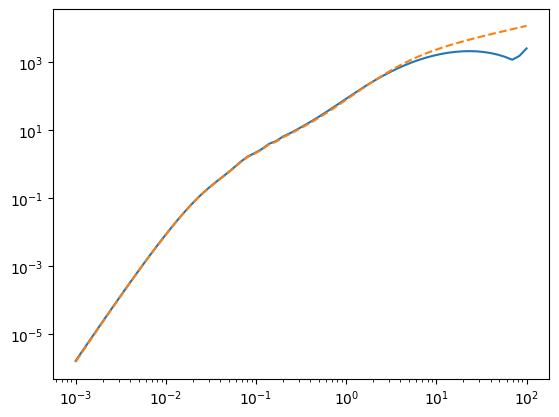

In [16]:
pl.figure()
pl.loglog(k_array_ccl, (k_array_ccl**3)*Pk_nfw[:,indz])
# pl.loglog(k_array_ccl, Pk_nfw[:,0])
pl.loglog(k_array_ccl, (k_array_ccl**3)*pkz_HF_ccl, '--')




In [115]:
from pyccl import background
z = 1.0
background.rho_x(cosmo, (1/(1+z)), 'matter', is_comoving=True)




38852641086.2362

In [124]:
from colossus.lss import mass_function
cosmology.setCosmology('myCosmo', **cosmo_params_dict)
mfunc_so = mass_function.massFunction(setup_power_BCMP_test.M_array, z_test, mdef = '200c', model = 'tinker08', q_out='dndlnM')



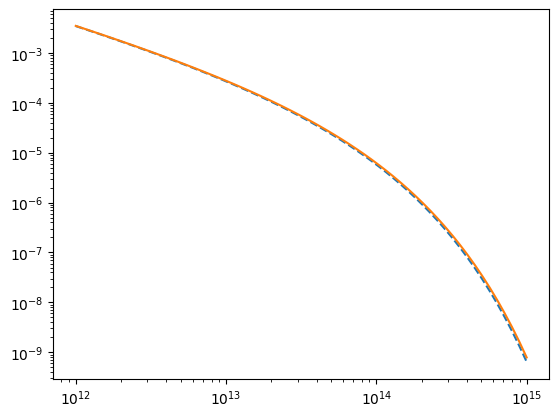

In [125]:
pl.figure()
pl.loglog(setup_power_BCMP_test.M_array, mfunc_so, '--')
pl.loglog(setup_power_BCMP_test.M_array, setup_power_BCMP_test.hmf_Mz_mat[indz,:])




In [162]:
from get_power_spectra_jit import get_power_BCMP
get_power_test = get_power_BCMP(sim_params_dict, halo_params_dict, analysis_dict, verbose_time=True)



Time taken to calculate BCMP profile:  4.009843587875366  seconds
Time taken to setup Pk:  2.6090519428253174
Time taken to setup HMF:  5.22732949256897
Time taken to setup uks and bks:  1.3119068145751953
Time taken to setup uls and bls:  2.283567190170288
Time taken to setup power spectra:  12.379555940628052
Time for setup_power_BCMP:  16.389838695526123
Time for computing Wk_mat:  0.2911381721496582
Time for computing p_logc_Mz:  0.0034215450286865234
Time for computing Cl_kappa_y_1h_mat:  0.25141358375549316
Time for computing Cl_kappa_y_2h_mat:  0.09697842597961426
Time for computing Cl_y_y_1h_mat:  0.13741087913513184
Time for computing Cl_y_y_2h_mat:  0.057927608489990234
Time for computing Cl_kappa_kappa_1h_mat:  0.18318915367126465
Time for computing Cl_kappa_kappa_2h_mat:  1.3387889862060547
Time for computing Cl_kappa_kappa_nfw_1h_mat:  0.18609046936035156
Time for computing Cl_kappa_kappa_2h_mat:  0.10256338119506836
Total time for computing all Cls:  19.041517734527588


(0.001, 10)

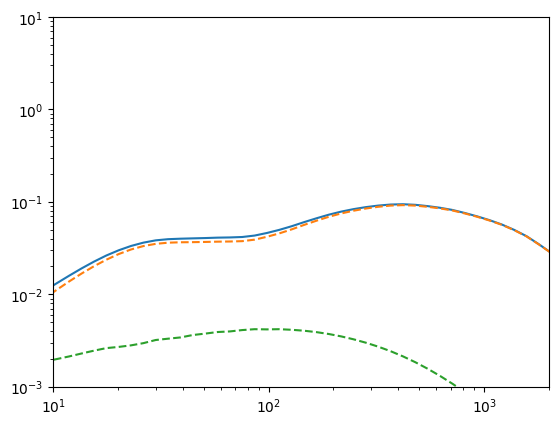

In [163]:
prefac = (get_power_test.ell_array)*(get_power_test.ell_array+1)/(2*np.pi)
pl.figure()
pl.loglog(get_power_test.ell_array, 1e12*prefac*(get_power_test.Cl_y_y_1h_mat + get_power_test.Cl_y_y_2h_mat))
pl.loglog(get_power_test.ell_array, 1e12*prefac*(get_power_test.Cl_y_y_1h_mat), ls='--')
pl.loglog(get_power_test.ell_array, 1e12*prefac*(get_power_test.Cl_y_y_2h_mat), ls='--')
pl.xlim(10,2000)
pl.ylim(1e-3, 10)




In [179]:
import copy
from tqdm import tqdm
from get_corr_func_jit import get_corrfunc_BCMP
get_corrfunc_BCMP_test = get_corrfunc_BCMP(sim_params_dict, halo_params_dict, analysis_dict, verbose_time=True)
# gty_out_all[jt,:] = get_corrfunc_BCMP_test.gty_out_mat[:,3]
# xip_out_all[jt,:] = get_corrfunc_BCMP_test.xip_out_mat[:,3,3]
# xim_out_all[jt,:] = get_corrfunc_BCMP_test.xim_out_mat[:,3,3]



Time taken to calculate BCMP profile:  4.030304193496704  seconds
Time taken to setup Pk:  2.6447901725769043
Time taken to setup HMF:  5.2687907218933105
Time taken to setup uks and bks:  1.315291404724121
Time taken to setup uls and bls:  2.3124873638153076
Time taken to setup power spectra:  12.497021436691284
Time for setup_power_BCMP:  16.52778124809265
Time for computing Wk_mat:  0.29435062408447266
Time for computing p_logc_Mz:  0.0035352706909179688
Time for computing Cl_kappa_y_1h_mat:  0.2257399559020996
Time for computing Cl_kappa_y_2h_mat:  0.10549116134643555
Time for computing Cl_y_y_1h_mat:  0.13907694816589355
Time for computing Cl_y_y_2h_mat:  0.05889749526977539
Time for computing Cl_kappa_kappa_1h_mat:  0.19975042343139648
Time for computing Cl_kappa_kappa_2h_mat:  0.10130810737609863
Time for computing Cl_kappa_kappa_nfw_1h_mat:  0.1960303783416748
Time for computing Cl_kappa_kappa_2h_mat:  0.10073351860046387
Total time for computing all Cls:  17.955349683761597
Ti

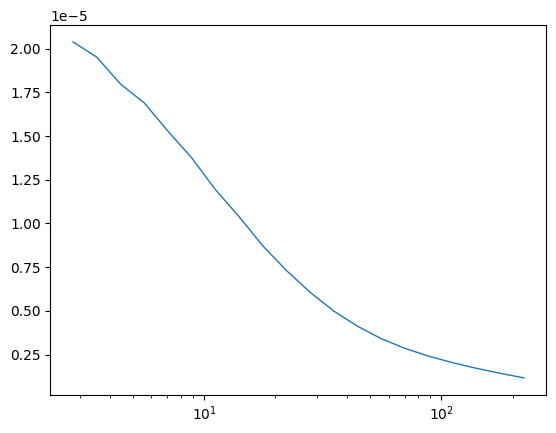

In [180]:
pl.figure()
pl.plot(analysis_dict['angles_data_array'], get_corrfunc_BCMP_test.xim_out_mat[:,3,3], alpha=1.0,lw=1.0)
# pl.plot(analysis_dict['angles_data_array'], get_corrfunc_BCMP_test.gty_out_mat[:,3], alpha=1.0,lw=1.0)
pl.xscale('log')



In [181]:
# from get_corr_func import get_corrfunc_BCMP
import copy
from tqdm import tqdm
from get_corr_func_jit import get_corrfunc_BCMP
sims_params_dict_vary = copy.deepcopy(sim_params_dict)
theta_ej_array = np.linspace(1.0, 6.0, 10)
# analysis_dict_vary = copy.deepcopy(analysis_dict)
gty_out_all = np.zeros((len(theta_ej_array), len(theta_data)))
xip_out_all = np.zeros((len(theta_ej_array), len(theta_data)))
xim_out_all = np.zeros((len(theta_ej_array), len(theta_data)))
for jt in tqdm(range(len(theta_ej_array))):
    sims_params_dict_vary['theta_ej'] = theta_ej_array[jt]
    # analysis_dict_vary['angles_data_array'] = jnp.logspace(np.log10(0.5), np.log10(100), len(theta_data))
    get_corrfunc_BCMP_test = get_corrfunc_BCMP(sims_params_dict_vary, halo_params_dict, analysis_dict, verbose_time=False)
    gty_out_all[jt,:] = get_corrfunc_BCMP_test.gty_out_mat[:,3]
    xip_out_all[jt,:] = get_corrfunc_BCMP_test.xip_out_mat[:,3,3]
    xim_out_all[jt,:] = get_corrfunc_BCMP_test.xim_out_mat[:,3,3]
    





100%|██████████| 10/10 [03:15<00:00, 19.50s/it]


/tmp/ipykernel_1632832/1999391064.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
100%|██████████| 10/10 [00:00<00:00, 362.99it/s]
/tmp/ipykernel_1632832/1999391064.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = pl.colorbar(sm)


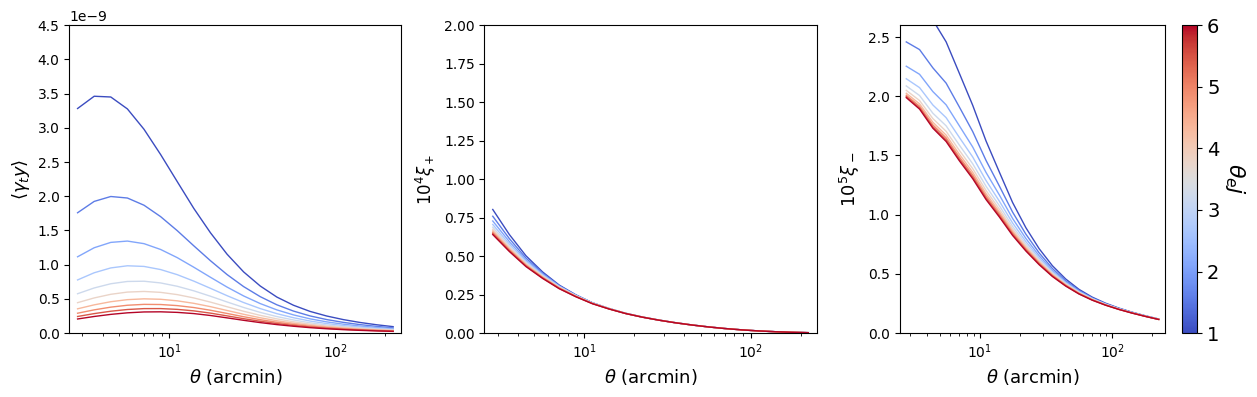

In [182]:
# make a three panel plot, plotting all the theta_ej curves for for gty_out_thetaej[:,3,:], xip_out_thetaej[:,3,3,:], xim_out_thetaej[:,3,3,:]
# draw theta_ej curves from a colormap
from matplotlib import cm, colorbar
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
# create a normalize object the scales the input Mc0 value to the range [0,1]
norm = Normalize(vmin=(theta_ej_array).min(), vmax=(theta_ej_array).max())
# analysis_dict_vary['angles_data_array'] = jnp.logspace(np.log10(0.5), np.log10(100), len(theta_data))

pl.figure(figsize=(15,4))
# increase the distance between subplots:
pl.subplots_adjust(wspace=0.25)
pl.subplot(131)
for jM in tqdm(range(len(theta_ej_array))):
    color = cmap(norm((theta_ej_array[jM])))
    pl.plot(analysis_dict['angles_data_array'], gty_out_all[jM,:], color=color, alpha=1.0,lw=1.0)
# pl.legend()
pl.xscale('log')
pl.xlim(2.5,250)
pl.ylim(0.0,4.5e-9)
pl.ylabel(r'$\langle \gamma_t y \rangle$', fontsize=13)
pl.xlabel(r'$\theta$ (arcmin)', fontsize=13)
# pl.title('1-halo term')
pl.subplot(132)
for jM in tqdm(range(len(theta_ej_array))):
    color = cmap(norm((theta_ej_array[jM])))
    pl.plot(analysis_dict['angles_data_array'], 1e4*xip_out_all[jM,:], color=color, alpha=1.0,lw=1.0)

# pl.legend()
pl.xscale('log')
pl.xlim(2.5,250)
pl.ylim(0.0,2)
pl.ylabel(r'$10^4 \xi_+$', fontsize=12)
pl.xlabel(r'$\theta$ (arcmin)', fontsize=13)
# pl.title('2-halo term')
pl.subplot(133)
for jM in tqdm(range(len(theta_ej_array))):
    color = cmap(norm((theta_ej_array[jM])))
    pl.plot(analysis_dict['angles_data_array'], 1e5*xim_out_all[jM,:], color=color, alpha=1.0,lw=1.0)

# pl.legend()
# pl.legend()
pl.xscale('log')
pl.xlim(2.5,250)
pl.ylim(0.0,2.6)
pl.ylabel(r'$10^5 \xi_-$', fontsize=13)
pl.xlabel(r'$\theta$ (arcmin)', fontsize=13)
# pl.title('2-halo term')

# create a ScalarMappable with the colormap and norm
sm = ScalarMappable(cmap=cmap, norm=norm)
# the array is not used in this case, but normally the values used for the colormap are passed here
sm.set_array([])
# add the colorbar to the figure
cbar = pl.colorbar(sm)
cbar.set_label(r'$\theta_ej$', fontsize=16, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=14)




